# WA Marketing A/B Test

## Table of Contents  <a id='back'></a>
- [Project Introduction](#project-introduction)
    - [Analysis Outline](#analysis-outline)
    - [Results](#results)
- [Importing Libraries and Opening Data Files](#importing-libraries-and-opening-data-files)
- [Pre-processing Data](#pre-processing-data)
    - [Header Style](#header-style)
    - [Duplicates](#duplicates)
    - [Missing Values](#missing-values)
    - [Data Usage and Formatting](#data-usage-and-formatting)
- [Data Analysis](#data-analysis)
- [A/B Test](#ab-test)
    - [ANOVA Test](#anova-test)
- [Conclusion](#conclusion)

<a name='headers'>

## Project Introduction

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. To determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks. The objective is to perform an A/B test and decide which marketing strategy is the optimal method for sales growth.

### Analysis Outline

- The ANOVA test was used, and the established hypothesis is:

    - (H0): M0 = M1 = M2 (There is not a statistical difference in the promotion groups)
    
    - (H1): M0 != M1 != M2 (There is a statistical difference in the promotion groups)

- Shapiro-Wilk test resulted in the significance level being less than 0.05, leading us to reject the null hypothesis, indicating that the assumption of equality is not met and that it is not a normal distribution

- In the case of non-normal distribution, we used the Kruskal–Wallis Test a non-parametric test. For this scenario, we are going to use the Kruskal–Wallis Test

### Results

Based on the results of this dataset, I uncovered that this fast-food business should use promotion strategies A/1 and/or C/3 for their future primary marketing campaign for optimal sales performance.

## Importing Libraries and Opening Data Files

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from scipy.stats import shapiro, kruskal
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt
import seaborn  as sns

In [2]:
# importing dataset
try:
    mc = pd.read_csv('wa_marketing_campaign.csv')
except:
    mc = pd.read_csv('/datasets/wa_marketing_campaign.csv')

[Back to Table of Contents](#back)

## Pre-processing Data

In [3]:
# Getting general information about the dataset
mc.info()
mc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


### Header Style

In [4]:
#checking for snakecase format
mc.columns

Index(['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion',
       'week', 'SalesInThousands'],
      dtype='object')

In [5]:
# Renaming and formatting column names to snake_case format
mc = mc.rename(columns={'MarketID': 'market_id',
                        'MarketSize': 'market_size',
                        'LocationID': 'location_id',
                        'AgeOfStore': 'store_age',
                        'Promotion': 'promotion_group',
                        'SalesInThousands': 'sales_in_thousands'})
mc.columns

Index(['market_id', 'market_size', 'location_id', 'store_age',
       'promotion_group', 'week', 'sales_in_thousands'],
      dtype='object')

[Back to Table of Contents](#back)

### Duplicates

In [6]:
# Checking for duplicates
mc.duplicated().sum()

0

[Back to Table of Contents](#back)

### Missing Values

In [7]:
# Checking for null values
mc.isna().sum()

market_id             0
market_size           0
location_id           0
store_age             0
promotion_group       0
week                  0
sales_in_thousands    0
dtype: int64

[Back to Table of Contents](#back)

### Data Usage and Formatting

In [8]:
# By using nunique we can find the total number of unique values in each column. Depending
# on the number of unique results we can change the column data types to reduce data usage.
mc.info()
mc.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   market_id           548 non-null    int64  
 1   market_size         548 non-null    object 
 2   location_id         548 non-null    int64  
 3   store_age           548 non-null    int64  
 4   promotion_group     548 non-null    int64  
 5   week                548 non-null    int64  
 6   sales_in_thousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


market_id              10
market_size             3
location_id           137
store_age              25
promotion_group         3
week                    4
sales_in_thousands    517
dtype: int64

In [9]:
mc['market_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [10]:
mc['market_size'].unique()

array(['Medium', 'Small', 'Large'], dtype=object)

In [11]:
# Changing column to snake_case format and changing data type to reduce data usage
mc['market_size'] = mc['market_size'].str.lower()
mc['market_size'] = mc['market_size'].astype('category')

In [12]:
mc['location_id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
       101, 102, 103, 104, 105, 106, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 301, 302, 303, 304, 305, 306, 307, 308, 309, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513,
       514, 515, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611,
       612, 613, 614, 615, 701, 702, 703, 704, 705, 706, 707, 708, 709,
       710, 711, 712, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810,
       901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913,
       914, 915, 916, 917, 918, 919, 920], dtype=int64)

In [13]:
mc['store_age'].unique()

array([ 4,  5, 12,  1, 10, 15,  6, 22,  8, 19, 11, 13,  3,  7,  2, 23,  9,
       28, 25, 14, 24, 18, 27, 17, 20], dtype=int64)

In [14]:
mc['promotion_group'].unique()

array([3, 2, 1], dtype=int64)

In [15]:
mc['promotion_group'] = mc['promotion_group'].astype('category')
mc['promotion_group'] = mc['promotion_group'].replace(1, 'a').replace(2, 'b').replace(3, 'c')

In [16]:
mc['week'].unique()

array([1, 2, 3, 4], dtype=int64)

In [17]:
mc['sales_in_thousands'].unique()

array([33.73, 35.67, 29.03, 39.25, 27.81, 34.67, 27.98, 27.72, 44.54,
       37.94, 45.49, 34.75, 39.28, 39.8 , 24.77, 30.98, 30.37, 24.82,
       37.47, 23.35, 32.9 , 22.18, 42.98, 26.68, 42.92, 42.16, 51.72,
       36.17, 30.08, 28.62, 25.4 , 27.26, 37.41, 38.64, 40.9 , 41.11,
       34.27, 29.3 , 23.93, 35.16, 33.42, 37.93, 33.85, 40.25, 35.85,
       36.24, 41.73, 37.32, 50.48, 36.88, 35.68, 46.45, 67.48, 65.57,
       68.42, 60.93, 61.59, 63.64, 54.68, 61.24, 62.93, 58.77, 70.6 ,
       65.06, 59.76, 66.11, 62.16, 64.04, 59.65, 57.04, 59.73, 56.72,
       58.55, 62.19, 53.14, 62.27, 86.14, 82.56, 79.36, 77.17, 88.73,
       85.21, 81.55, 94.17, 89.7 , 78.43, 84.05, 81.18, 87.43, 81.79,
       88.12, 75.29, 83.02, 90.3 , 85.18, 89.77, 82.64, 82.89, 82.13,
       88.91, 87.7 , 81.16, 81.58, 94.21, 96.48, 84.13, 91.98, 81.72,
       93.71, 96.01, 93.03, 97.61, 85.11, 88.07, 94.43, 89.44, 88.64,
       81.37, 82.14, 79.64, 84.34, 87.9 , 76.12, 82.72, 73.22, 75.88,
       78.01, 80.17,

In [18]:
mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   market_id           548 non-null    int64   
 1   market_size         548 non-null    category
 2   location_id         548 non-null    int64   
 3   store_age           548 non-null    int64   
 4   promotion_group     548 non-null    category
 5   week                548 non-null    int64   
 6   sales_in_thousands  548 non-null    float64 
dtypes: category(2), float64(1), int64(4)
memory usage: 22.9 KB


[Back to Table of Contents](#back)

## Data Analysis

In [19]:
#
mc.describe()


,market_id,location_id,store_age,week,sales_in_thousands
count,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.500000,53.466204
std,2.877001,287.973679,6.638345,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,4.000000,99.650000


In [20]:
mc.groupby(['market_size', 'promotion_group']).agg({'location_id': 'count',
                                                    'sales_in_thousands': ['mean', 'sum']}).round(2)

location_id sales_in_thousands         
                                  count               mean      sum
market_size promotion_group                                        
large       a                        56              75.24  4213.21
            b                        64              60.32  3860.61
            c                        48              77.20  3705.79
medium      a                        96              47.67  4576.57
            b                       108              39.11  4224.35
            c                       116              45.47  5274.39
small       a                        20              60.16  1203.25
            b                        16              50.81   812.97
            c                        24              59.51  1428.34

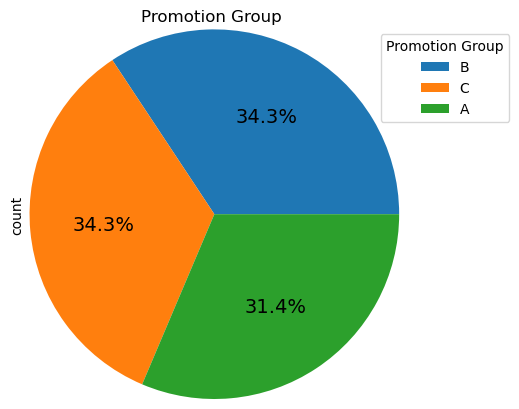

promotion_group
b    188
c    188
a    172
Name: count, dtype: int64

In [21]:
mc['promotion_group'].value_counts().plot(kind='pie',
                                          autopct='%1.1f%%',
                                          fontsize=14,
                                          labels=['', '', ''],
                                          radius=1.25)
plt.title('Promotion Group ')
plt.legend(['B', 'C', 'A'],
           title='Promotion Group',
           loc=[0.95,.75])
plt.show()
mc['promotion_group'].value_counts()

C:\Users\jason\AppData\Local\Temp\ipykernel_8856\540127839.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mc, x='promotion_group', y='sales_in_thousands', hue='market_size', ci=None)


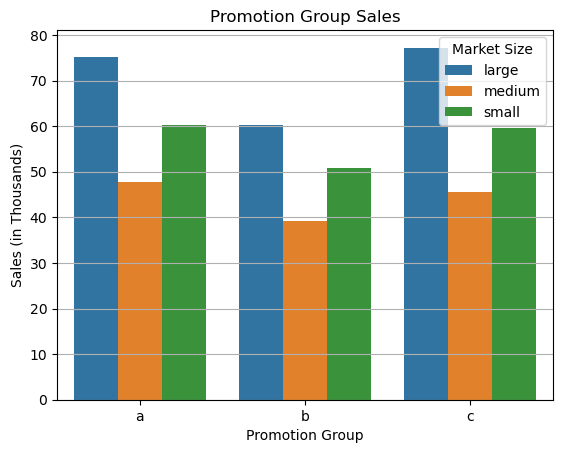

In [22]:
sns.barplot(data=mc, x='promotion_group', y='sales_in_thousands', hue='market_size', ci=None)
plt.title('Promotion Group Sales')
plt.grid(axis='y')
plt.xlabel('Promotion Group')
plt.ylabel('Sales (in Thousands)')
plt.legend(title='Market Size')
plt.show()

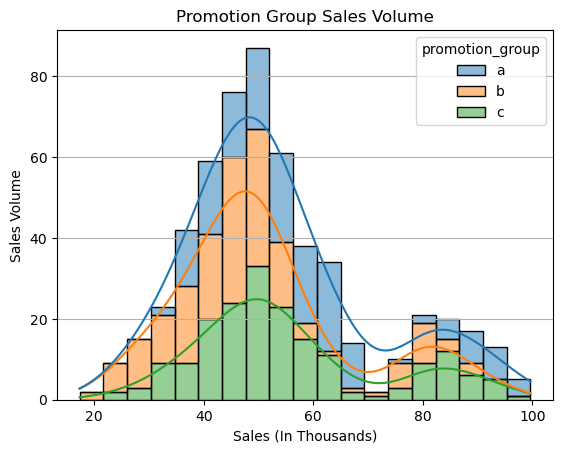

In [23]:
sns.histplot(data=mc, x='sales_in_thousands', hue='promotion_group', multiple='stack', kde=True)
plt.title('Promotion Group Sales Volume')
plt.grid(axis='y')
plt.xlabel('Sales (In Thousands)')
plt.ylabel('Sales Volume')
plt.show()

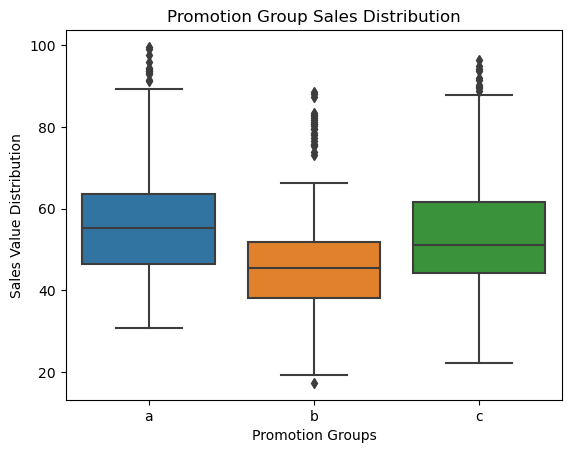

In [24]:
sns.boxplot(data=mc, x='promotion_group', y='sales_in_thousands')
plt.title('Promotion Group Sales Distribution')
plt.xlabel('Promotion Groups')
plt.ylabel('Sales Value Distribution')
plt.show()

[Back to Table of Contents](#back)

## A/B Test

### ANOVA Test

When performing an A/B test it is important to test your hypothesis to see if there is a statistically significant difference among test groups. For this dataset, since it contains more than two testing groups, I will use an analysis of variance (ANOVA) testing method that is designed to compare more than two testing groups. The ANOVA test compares the variance between groups with the variance within the group.

Established hypothesis:

    - (H0): M0 = M1 = M2 (There is not a statistical difference in the promotion groups)
    
    - (H1): M0 != M1 != M2 (There is a statistical difference in the promotion groups)

For this test, we are going to use a significant level of 0.05. If the calculated p-value is greater than the significance level, then we can safely assume there is no statistically significant difference in testing groups, and we fail to reject the null hypothesis (H0). However, if the calculated p-value is less than the significance level, then there is a more significant statistical difference between at least one of the testing groups and we reject the null hypothesis (H0). The outcome will dictate how we will proceed with the test:

    - If the normality assumption is met and we do not reject the null hypothesis we continue to the Homogeneity Test
    
    - If the normality assumption is not met and we reject the null hypothesis then we switch to a non-parametric testing method (Kruskal-Wallis Test)


In [25]:
# Normality Assumption - Shapiro-Wilk Test

for group in list(mc['promotion_group'].unique()):
    p_value = shapiro(mc.loc[mc['promotion_group'] == group, 'sales_in_thousands'])[1]
    print(group, 'p-value: %.4f' % p_value)

# Since the p-value > 0.05 then we have reason to reject the null hypothesis which indicates that is not a normal distribution
# In the case of non-normal distribution we can then use a non-parametric test. For this scenario we are going to use the Kruskal–Wallis Test

c p-value: 0.0000
b p-value: 0.0000
a p-value: 0.0000


In [26]:
# Kruskal–Wallis Non-Parametric Test 

s,p = kruskal(mc.loc[mc['promotion_group']=='a', 'sales_in_thousands'],
              mc.loc[mc['promotion_group']=='b', 'sales_in_thousands'],
              mc.loc[mc['promotion_group']=='c', 'sales_in_thousands'])
print(f'\nStatistic: {s:.3f}\np-value: {p:.3f}\n')

# Since the p-value > 0.05 then we have reason to reject the null hypothesis showing there is a significant statistical difference in promotion groups



Statistic: 53.295
p-value: 0.000



In [27]:
# We should also check for which groups are significantly different

multi_comparison = MultiComparison(mc['sales_in_thousands'], mc['promotion_group'])
tukey = multi_comparison.tukeyhsd(0.05)
print(tukey.summary())

# Only when comparing groups a and c shows that there is no significant difference in marketing groups
# The other group comparisons shows there is a significant difference in marketing groups

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     a      b -10.7696    0.0 -14.7738 -6.7654   True
     a      c  -2.7345 0.2444  -6.7388  1.2697  False
     b      c   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


[Back to Table of Contents](#back)

## Conclusion

A/B testing is an very useful tool that most businesses can apply to their business strategies to compare various ideas and marketing strategies without completely committing to one or another. Based on the results of this dataset, I uncovered that this fast food company should use promotion strategies A/1 and/or C/3 for their future primary marketing campaign for optimal sales performance.

[Back to Table of Contents](#back)